In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.signal
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.interpolate import interp1d
from pydub import AudioSegment
import pywt
import optimalK
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.utils import shuffle
from collections import Counter
import itertools
import os
import pickle
import random
import cProfile
from collections import defaultdict

In [2]:
folder_path = '../audios/lab_audios/first_batch/'
with open(f'{folder_path}all_segments.pkl', 'rb') as file:
    all_segments = pickle.load(file)

In [3]:
def band_stop_filter(y, sr, highcut, order=4):
    nyquist = 0.5 * sr
    normal_cutoff = highcut / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = scipy.signal.filtfilt(b, a, y)
    return y_filtered

def process_individual_snippets_with_fft(all_segments, file_names, sr=None):
    processed_segments_fft = []
    
    file_idx = 0
    while file_idx < len(file_names):
        file_name = file_names[file_idx]
        print(f"Loading file: {file_name}")
        
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            file_idx += 1
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]

        for idx, segment in enumerate(file_segments):
            start_time = segment['start_time']
            end_time = segment['end_time']
            
            print(f"Processing snippet {idx + 1}/{len(file_segments)}: {start_time:.2f}s to {end_time:.2f}s")

            start_idx = int(start_time * original_sr)
            end_idx = int(end_time * original_sr)
            
            snippet = y[start_idx:end_idx]
            
            fft_result = np.fft.fft(snippet)
            fft_magnitude = np.abs(fft_result)
            fft_frequencies = np.fft.fftfreq(len(snippet), d=1/original_sr)  # Get frequencies
            
            processed_segments_fft.append({
                'file_name': file_name,
                'start_time': start_time,
                'end_time': end_time,
                'fft_magnitude': fft_magnitude,
                'fft_frequencies': fft_frequencies
            })

        file_idx += 1

    return processed_segments_fft


In [4]:
folder_path = '../audios/lab_audios/first_batch/'
file_names = [f'{folder_path}recording_20240927_204919-{i:02d}.wav' for i in range(1, 17)]
# processed_segments_fft = process_individual_snippets_with_fft(all_segments, file_names)

# # Save the results if needed
# with open(f'{folder_path}processed_segments_fft.pkl', 'wb') as file:
#     pickle.dump(processed_segments_fft, file)

# print("FFT processing complete. Results saved.")


with open(f'{folder_path}processed_segments_fft.pkl', 'rb') as file:
    processed_segments_fft = pickle.load(file)

In [5]:
for segment in processed_segments_fft:
    # Get the fft_frequencies and fft_magnitude fields
    fft_frequencies = segment['fft_frequencies']
    fft_magnitude = segment['fft_magnitude']
    
    # Filter for non-negative frequencies
    non_negative_indices = fft_frequencies >= 0
    segment['fft_frequencies'] = fft_frequencies[non_negative_indices]
    segment['fft_magnitude'] = fft_magnitude[non_negative_indices]

print("Negative frequencies have been removed from all segments.")

Negative frequencies have been removed from all segments.


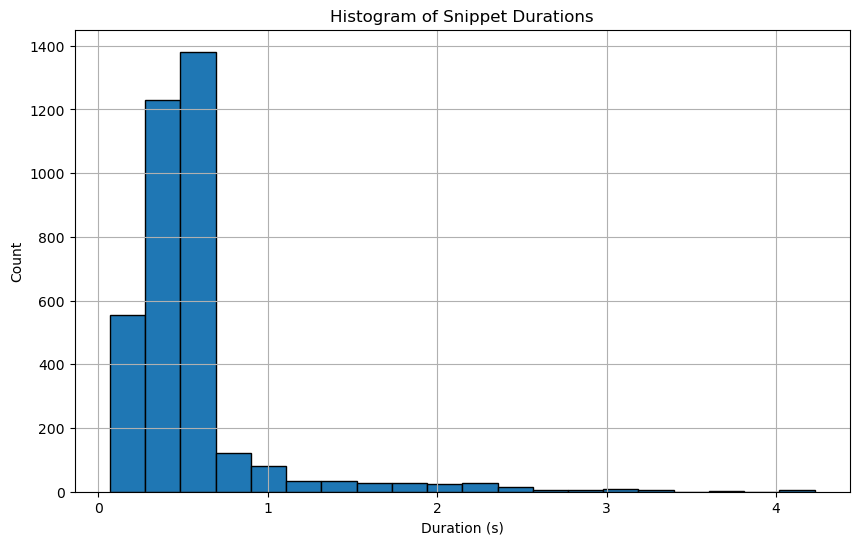

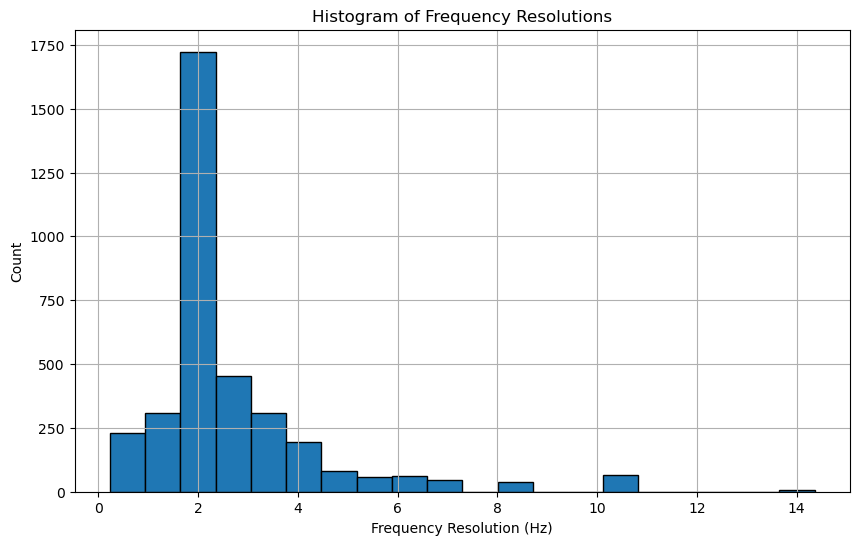

In [6]:
durations = [segment['end_time'] - segment['start_time'] for segment in processed_segments_fft]
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, edgecolor='black')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.title('Histogram of Snippet Durations')
plt.grid(True)
plt.show()

frequency_resolutions = []
for segment in processed_segments_fft:
    fft_frequencies = segment['fft_frequencies']
    positive_frequencies = fft_frequencies[fft_frequencies >= 0]  # Only positive frequencies
    resolution = np.min(np.diff(positive_frequencies))
    frequency_resolutions.append(resolution)

plt.figure(figsize=(10, 6))
plt.hist(frequency_resolutions, bins=20, edgecolor='black')
plt.xlabel('Frequency Resolution (Hz)')
plt.ylabel('Count')
plt.title('Histogram of Frequency Resolutions')
plt.grid(True)
plt.show()

In [7]:
print(processed_segments_fft[0]['fft_magnitude'][0])

0.011074838859822193


In [8]:
def plot_multiple_fft_magnitudes(segments, num_segments_to_plot=10):
    plt.figure(figsize=(15, 10))
    for i, segment in enumerate(segments[:num_segments_to_plot], start=1):
        fft_magnitude = segment['fft_magnitude']
        fft_frequencies = segment['fft_frequencies']
        
        plt.subplot(2, 5, i)
        plt.plot(fft_frequencies, fft_magnitude)
        plt.title(f"Segment {i}")
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.grid()
    
    plt.tight_layout()
    plt.show()


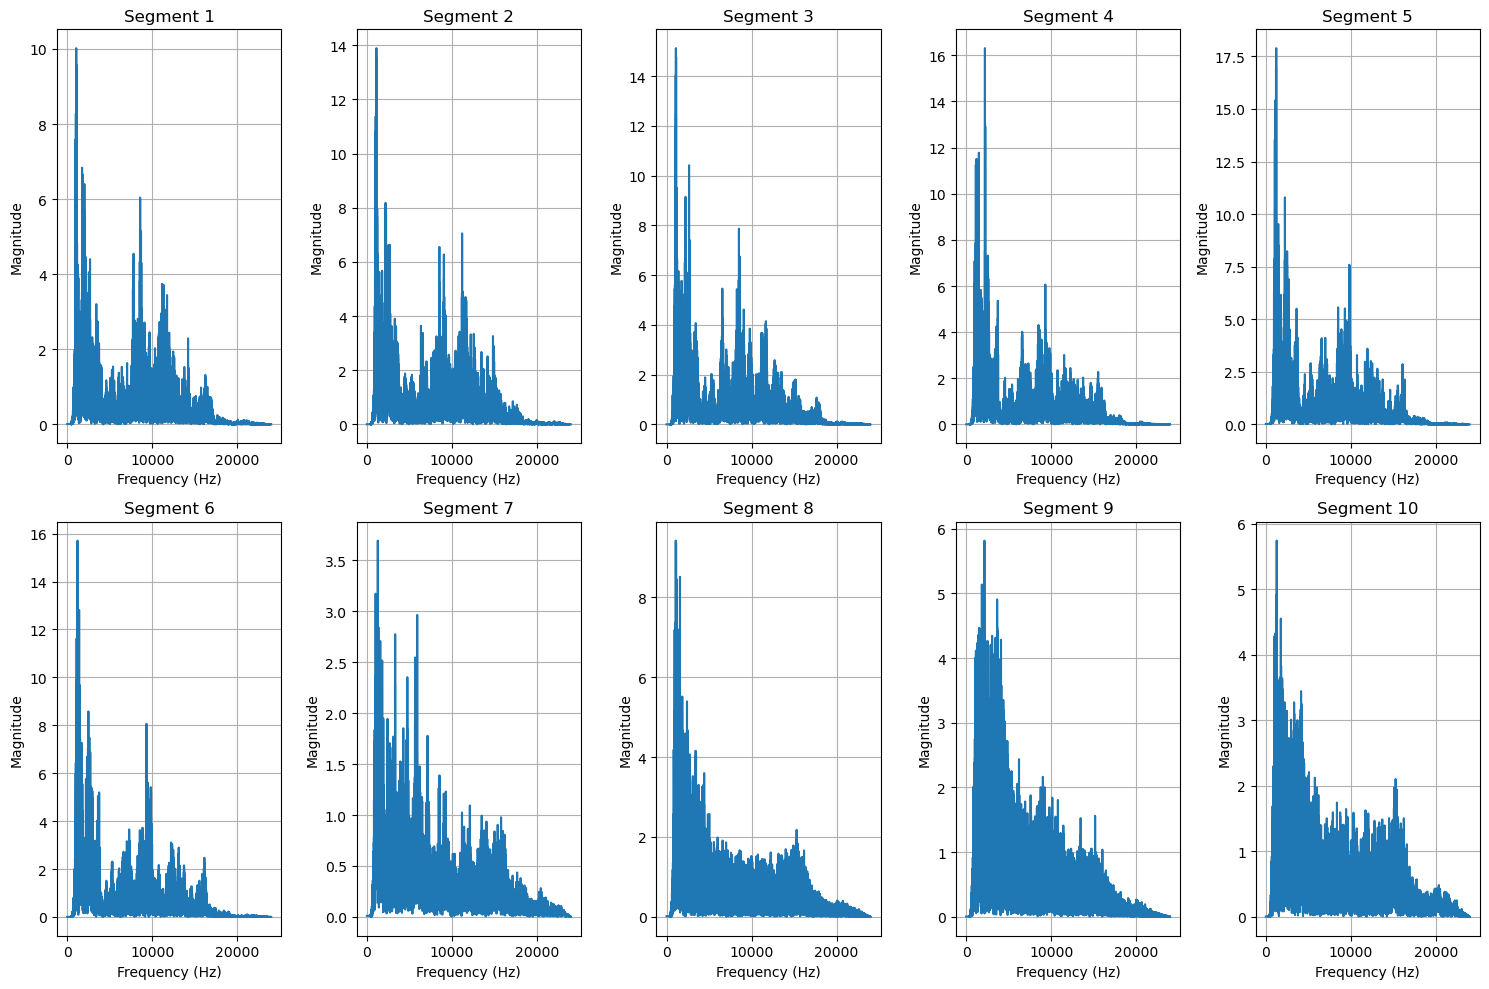

In [9]:
plot_multiple_fft_magnitudes(processed_segments_fft, num_segments_to_plot=10)


In [10]:
def pad_fft_magnitudes(processed_segments_fft):
    max_length = max(len(segment['fft_magnitude']) for segment in processed_segments_fft)

    for segment in processed_segments_fft:
        fft_magnitude = segment['fft_magnitude']
        padded_magnitude = np.pad(fft_magnitude, (0, max_length - len(fft_magnitude)), mode='constant')
        segment['padded_fft_magnitude'] = padded_magnitude

    return processed_segments_fft

In [11]:
processed_segments_fft = pad_fft_magnitudes(processed_segments_fft)

In [12]:
def verify_frequency_resolution(processed_segments_fft):
    frequency_resolutions = []
    for idx, segment in enumerate(processed_segments_fft):
        fft_frequencies = segment['fft_frequencies']
        delta_f = np.diff(fft_frequencies)
        
        if not np.allclose(delta_f, delta_f[0]):
            print(f"Warning: Non-uniform frequency resolution in segment {idx + 1}")
        
        frequency_resolutions.append(delta_f[0])

    if not np.allclose(frequency_resolutions, frequency_resolutions[0]):
        print("Frequency resolutions vary across segments!")
    else:
        print(f"Frequency resolution is consistent: {frequency_resolutions[0]:.2f} Hz")
    
    return frequency_resolutions

In [13]:
frequency_resolutions = verify_frequency_resolution(processed_segments_fft)

Frequency resolutions vary across segments!


In [14]:
finest_delta_f = min([np.min(np.diff(segment['fft_frequencies'])) for segment in processed_segments_fft])

min_freq = min([min(segment['fft_frequencies']) for segment in processed_segments_fft])
max_freq = max([max(segment['fft_frequencies']) for segment in processed_segments_fft])

common_frequencies = np.arange(min_freq, max_freq, finest_delta_f)

In [15]:
def interpolate_fft_magnitudes(processed_segments_fft, common_frequencies):
    for segment in processed_segments_fft:
        segment['common_frequencies'] = common_frequencies
        fft_frequencies = segment['fft_frequencies']
        fft_magnitude = segment['fft_magnitude']
        
        interp_func = interp1d(fft_frequencies, fft_magnitude, kind='cubic', bounds_error=False, fill_value=0)
        
        interpolated_magnitude = interp_func(common_frequencies)
        segment['interpolated_fft_magnitude'] = interpolated_magnitude
    
    return processed_segments_fft

In [16]:
processed_segments_fft = interpolate_fft_magnitudes(processed_segments_fft, common_frequencies)

for idx, segment in enumerate(processed_segments_fft[:5]):
    print(f"Segment {idx + 1}: Interpolated magnitude shape = {segment['interpolated_fft_magnitude'].shape}")

Segment 1: Interpolated magnitude shape = (101425,)
Segment 2: Interpolated magnitude shape = (101425,)
Segment 3: Interpolated magnitude shape = (101425,)
Segment 4: Interpolated magnitude shape = (101425,)
Segment 5: Interpolated magnitude shape = (101425,)


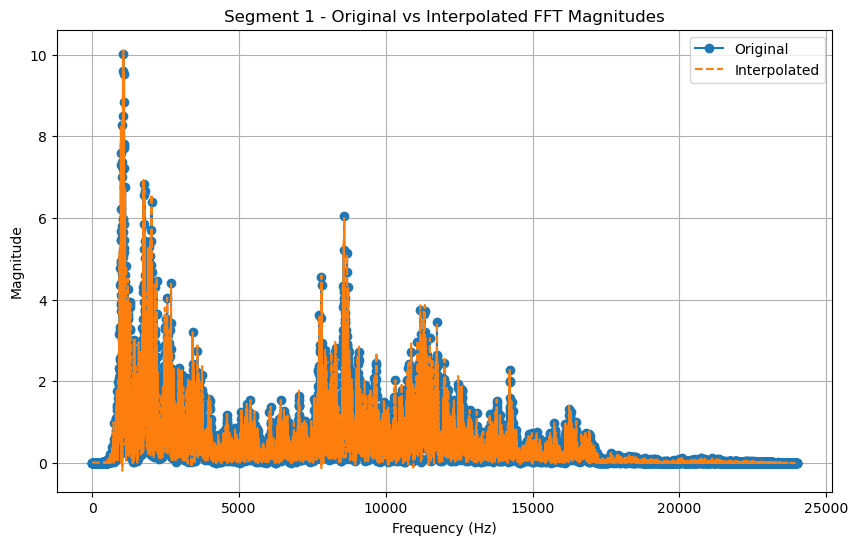

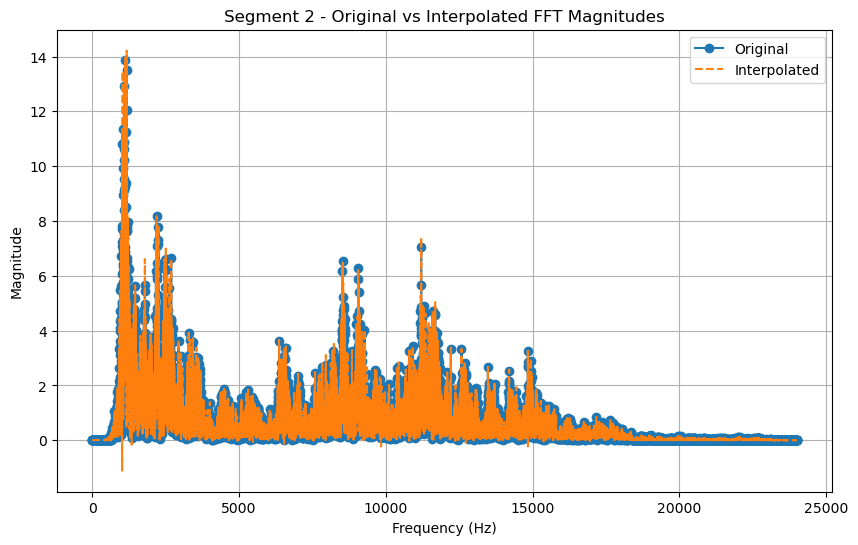

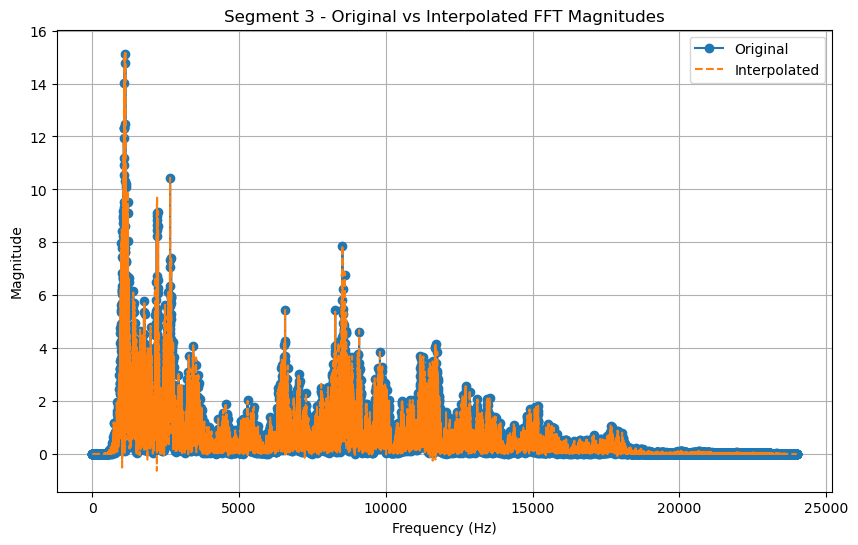

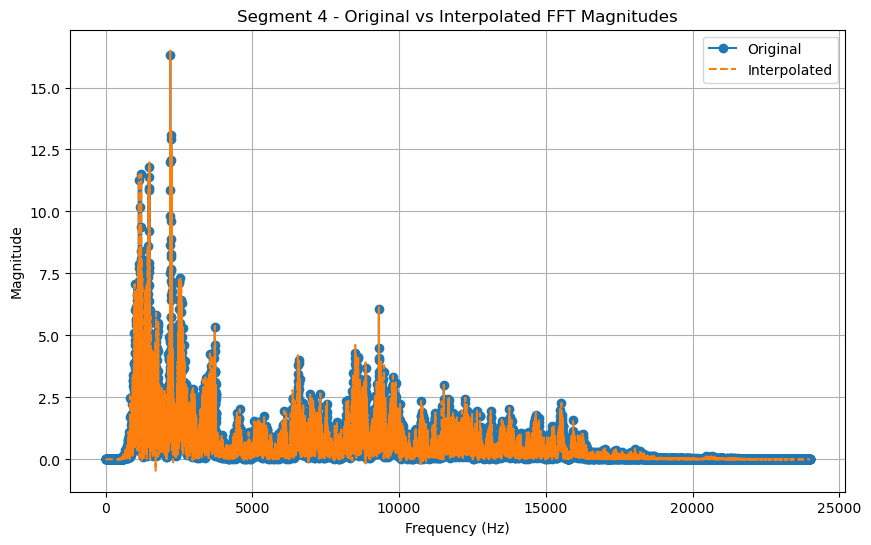

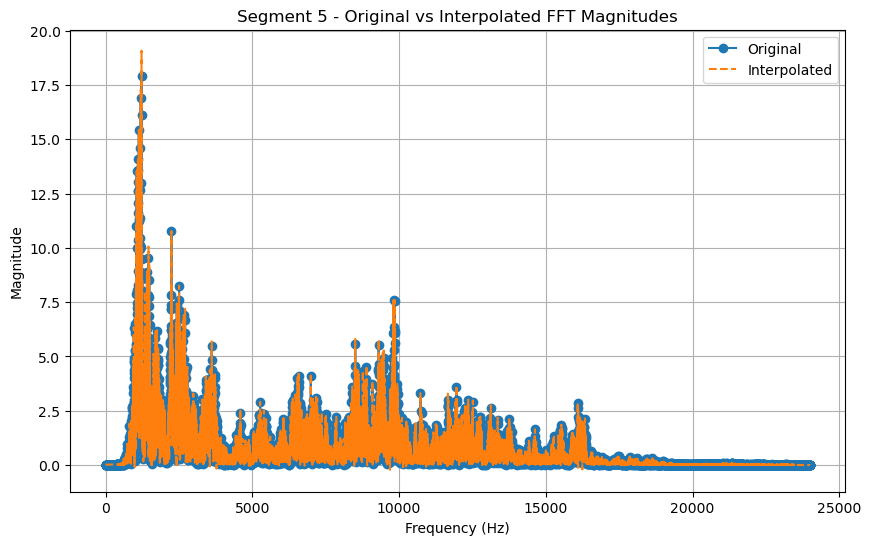

In [17]:
# examine artifacts
for i, segment in enumerate(processed_segments_fft[:5]):
    plt.figure(figsize=(10, 6))
    plt.plot(segment['fft_frequencies'], segment['fft_magnitude'], label='Original', marker='o')
    plt.plot(segment['common_frequencies'], segment['interpolated_fft_magnitude'], label='Interpolated', linestyle='--')
    plt.title(f"Segment {i + 1} - Original vs Interpolated FFT Magnitudes")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
errors = []
for segment in processed_segments_fft:
    interp_func = interp1d(segment['common_frequencies'], segment['interpolated_fft_magnitude'], 
                           kind='cubic', bounds_error=False, fill_value=0)
    interpolated_on_original = interp_func(segment['fft_frequencies'])
    error = np.sqrt(np.mean((segment['fft_magnitude'] - interpolated_on_original) ** 2))
    errors.append(error)

print(f"Mean RMSE: {np.mean(errors):.4f}, Max RMSE: {np.max(errors):.4f}")

Mean RMSE: 0.0009, Max RMSE: 0.0978


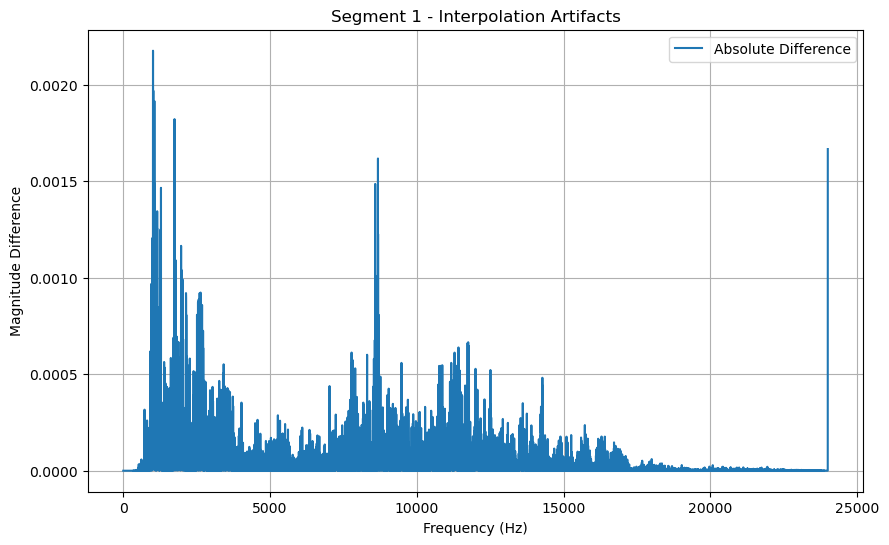

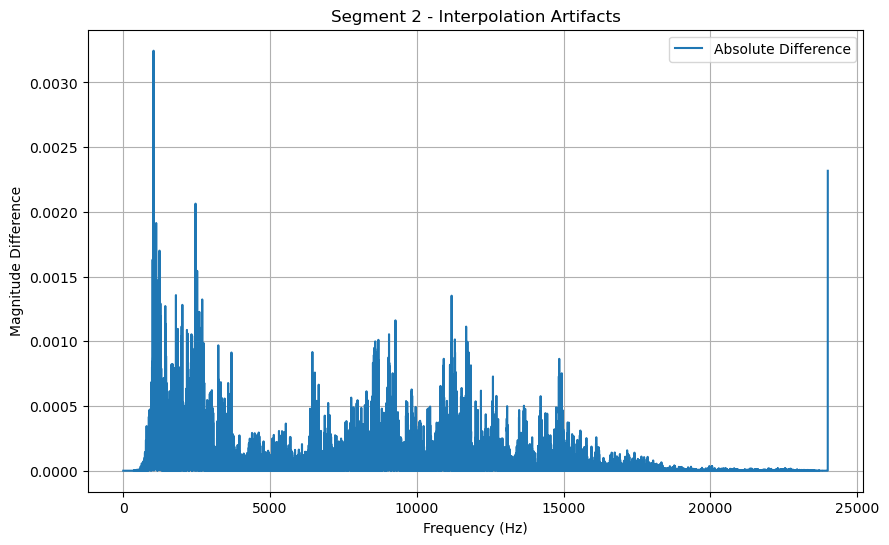

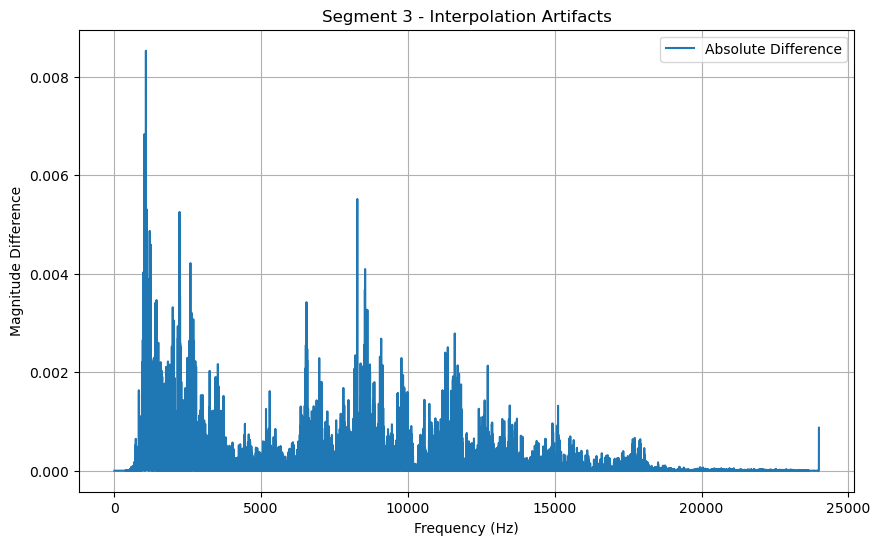

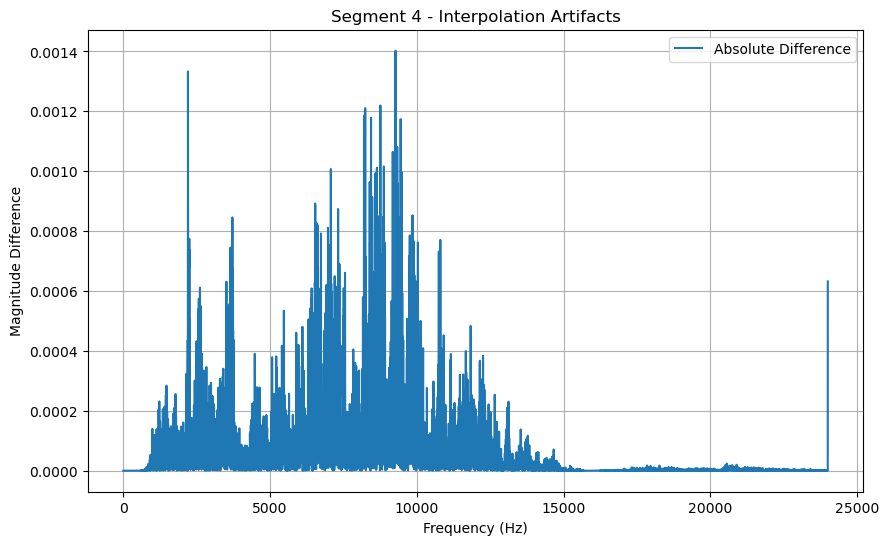

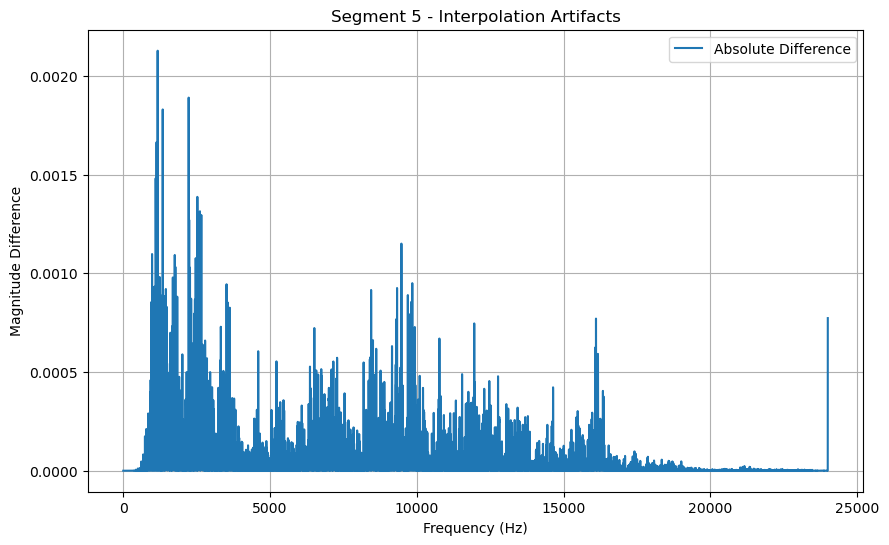

In [19]:
for i, segment in enumerate(processed_segments_fft[:5]):
    plt.figure(figsize=(10, 6))
    original_frequencies = segment['fft_frequencies']
    interp_func = interp1d(segment['common_frequencies'], segment['interpolated_fft_magnitude'], 
                           kind='cubic', bounds_error=False, fill_value=0)
    interpolated_on_original = interp_func(original_frequencies)
    differences = np.abs(segment['fft_magnitude'] - interpolated_on_original)

    plt.plot(original_frequencies, differences, label="Absolute Difference")
    plt.title(f"Segment {i + 1} - Interpolation Artifacts")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude Difference")
    plt.legend()
    plt.grid()
    plt.show()

In [20]:
def spectral_clustering_workflow(processed_segments, n_clusters=5, source='fft'):
    if source == 'fft':
        print("Extracting and standardizing FFT magnitudes...")
        magnitudes = np.array([segment['interpolated_fft_magnitude'] for segment in processed_segments])
    elif source == 'DWT':
        print("Extracting and standardizing DWT magnitudes...")
        magnitudes = np.array([np.vstack(segment['padded_power_levels']).flatten() for segment in processed_segments])
    scaler = StandardScaler()
    magnitudes_scaled = scaler.fit_transform(magnitudes)

    print(f"Performing spectral clustering with {n_clusters} clusters...")
    spectral_clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='nearest_neighbors',
        random_state=42
    )
    labels = spectral_clustering.fit_predict(magnitudes_scaled)

    for i, segment in enumerate(processed_segments):
        segment['cluster'] = labels[i]

#     print("Visualizing cluster sizes...")
    unique_labels, counts = np.unique(labels, return_counts=True)
#     plt.figure(figsize=(8, 6))
#     plt.bar(unique_labels, counts)
#     plt.xlabel('Cluster')
#     plt.ylabel('Number of Segments')
#     plt.title('Cluster Sizes')
#     plt.show()

    print("Analyzing and visualizing average magnitudes per cluster...")
#     plt.figure(figsize=(10, 6))
    for cluster_id in unique_labels:
        if source == 'fft':
            cluster_magnitudes = [segment['interpolated_fft_magnitude'] for segment in processed_segments if segment['cluster'] == cluster_id]
        elif source == 'DWT':
            cluster_magnitudes = [segment['padded_power_levels'] for segment in processed_segments if segment['cluster'] == cluster_id]
        avg_magnitude = np.mean(cluster_magnitudes, axis=0)
#         plt.plot(avg_magnitude, label=f"Cluster {cluster_id}")

#     plt.xlabel('Frequency Bin')
#     plt.ylabel('Average Magnitude')
#     plt.title('Average FFT Magnitudes for Clusters')
#     plt.legend()
#     plt.grid()
#     plt.show()

    print("Grouping segments by clusters...")
    clusters = defaultdict(list)
    for segment in processed_segments:
        clusters[segment['cluster']].append(segment)

    return clusters

In [21]:
# Run the clustering workflow
n_clusters = 15
clusters = spectral_clustering_workflow(processed_segments_fft, n_clusters=n_clusters)

# Access clusters for further analysis
for cluster_id, cluster_segments in clusters.items():
    print(f"Cluster {cluster_id} contains {len(cluster_segments)} segments.")


Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 15 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Cluster 0 contains 1777 segments.
Cluster 14 contains 307 segments.
Cluster 11 contains 51 segments.
Cluster 12 contains 208 segments.
Cluster 4 contains 946 segments.
Cluster 3 contains 22 segments.
Cluster 8 contains 90 segments.
Cluster 6 contains 47 segments.
Cluster 7 contains 27 segments.
Cluster 13 contains 16 segments.
Cluster 1 contains 21 segments.
Cluster 5 contains 15 segments.
Cluster 9 contains 19 segments.
Cluster 10 contains 18 segments.
Cluster 2 contains 20 segments.


In [22]:
def compute_null_distribution(processed_segments, n_clusters, num_iterations=100, ground_truth=None, source='fft'):
    if ground_truth is not None:
        observed_clusters = spectral_clustering_workflow(processed_segments, n_clusters=n_clusters, source=source)
        observed_labels = get_cluster_labels(observed_clusters)

        observed_score = adjusted_rand_score(ground_truth_labels, observed_labels)

        null_scores = []

        for i in range(num_iterations):
            print(f"Iteration {i + 1}/{num_iterations}...")

            shuffled_segments = shuffle(processed_segments, random_state=i)
            null_clusters = spectral_clustering_workflow(shuffled_segments, n_clusters=n_clusters, source=source)
            null_labels = get_cluster_labels(null_clusters)

            similarity_score = adjusted_rand_score(ground_truth_labels, null_labels)
            null_scores.append(similarity_score)

        return null_scores, observed_score
    else:
        observed_clusters = spectral_clustering_workflow(processed_segments, n_clusters=n_clusters, source=source)
        observed_labels = get_cluster_labels(observed_clusters)

        null_scores = []

        for i in range(num_iterations):
            print(f"Iteration {i + 1}/{num_iterations}...")

            shuffled_segments = shuffle(processed_segments, random_state=i)

            null_clusters = spectral_clustering_workflow(shuffled_segments, n_clusters=n_clusters)
            null_labels = get_cluster_labels(null_clusters)

            similarity_score = adjusted_rand_score(observed_labels, null_labels)
            null_scores.append(similarity_score)

        return null_scores, observed_labels

def get_cluster_labels(clusters):
    labels = []
    for cluster_id, cluster_segments in clusters.items():
        labels.extend([cluster_id] * len(cluster_segments))
    return labels

# Visualize results
def visualize_null_distribution(null_scores, observed_score):    
    plt.hist(null_scores, bins=20, alpha=0.7, label='Null Distribution')
    plt.axvline(observed_score, color='red', linestyle='dashed', label='Observed Score')
    plt.xlabel('ARI')
    plt.ylabel('Frequency')
    plt.title('Null Distribution of Clustering Similarity')
    plt.legend()
    plt.show()

In [23]:
# n_clusters = 15
# num_iterations = 100

# null_scores, observed_labels = compute_null_distribution(processed_segments_fft, n_clusters, num_iterations)
# observed_score = adjusted_rand_score(observed_labels, observed_labels)  # Self-comparison

# visualize_null_distribution(null_scores, observed_score)

In [24]:
# 'ground truth'
pkl_output_path = '../audios/lab_audios/first_batch/200RandomSegments.pkl'
with open(pkl_output_path, 'rb') as pkl_file:
    random_segments = pickle.load(pkl_file)
    
# processed_random_segments_fft = process_individual_snippets_with_fft(random_segments[:100], file_names)

# with open(f'{folder_path}processed_random_segments_FFT.pkl', 'wb') as file:
#     pickle.dump(processed_random_segments_fft, file)
    
with open(f'{folder_path}processed_random_segments_FFT.pkl', 'rb') as file:
    processed_random_segments_fft = pickle.load(file)

for segment in processed_random_segments_fft:
    # Get the fft_frequencies and fft_magnitude fields
    fft_frequencies = segment['fft_frequencies']
    fft_magnitude = segment['fft_magnitude']
    
    # Filter for non-negative frequencies
    non_negative_indices = fft_frequencies >= 0
    segment['fft_frequencies'] = fft_frequencies[non_negative_indices]
    segment['fft_magnitude'] = fft_magnitude[non_negative_indices]

print("Negative frequencies have been removed from all segments.")

finest_delta_f = min([np.min(np.diff(segment['fft_frequencies'])) for segment in processed_random_segments_fft])

min_freq = min([min(segment['fft_frequencies']) for segment in processed_random_segments_fft])
max_freq = max([max(segment['fft_frequencies']) for segment in processed_random_segments_fft])

common_frequencies = np.arange(min_freq, max_freq, finest_delta_f)

processed_random_segments_fft = interpolate_fft_magnitudes(processed_random_segments_fft, common_frequencies)

Negative frequencies have been removed from all segments.


In [25]:
random_c0 = [1,3,7,8]
random_c1 = [4,9,12,16,18,19,22,23,24,25,26,30,34,35,36,37,39,41,42,43,45,46,47,54,56,58,62,63,68,70,73,75,77,78,83,84,85,87,89,90,93,96,100,49,2,10,32,38]
random_c2 = [11,13,14,33,40,44,50,52,55,57,59,60,71,76,80,81,82,86,92,94,97,61,5,28,29,48,65,66,72,91]
random_c3 = [17,20,27,31,51,64,69,79,98]
random_c4 = [53,67,74,88]
random_c5 = [95,6,21,99]
random_c6 = [15]

random_c0 = [i - 1 for i in random_c0]
random_c1 = [i - 1 for i in random_c1]
random_c2 = [i - 1 for i in random_c2]
random_c3 = [i - 1 for i in random_c3]
random_c4 = [i - 1 for i in random_c4]
random_c5 = [i - 1 for i in random_c5]
random_c6 = [i - 1 for i in random_c6]

cluster_to_segments = {
    0: random_c0,
    1: random_c1,
    2: random_c2,
    3: random_c3,
    4: random_c4,
    5: random_c5,
    6: random_c6,
}

100
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 1/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 2/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 3/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 4/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Gro

Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 40/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 41/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 42/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 43/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 44/100...
Extracting and standardizing FFT magnitudes...


Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 80/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 81/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 82/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 83/100...
Extracting and standardizing FFT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 84/100...
Extracting and standardizing FFT magnitudes...


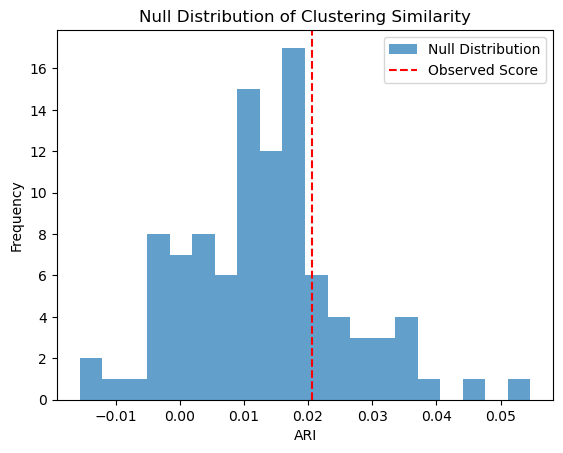

In [26]:
ground_truth_labels = np.zeros(100, dtype=int)

for cluster_id, indices in cluster_to_segments.items():
    for idx in indices:
        ground_truth_labels[idx] = cluster_id

        
print(len(processed_random_segments_fft))
num_iterations = 100
n_clusters = 7
null_scores, observed_score = compute_null_distribution(
    processed_random_segments_fft,
    ground_truth=ground_truth_labels,
    n_clusters=n_clusters,
    num_iterations=num_iterations
)

visualize_null_distribution(null_scores, observed_score)

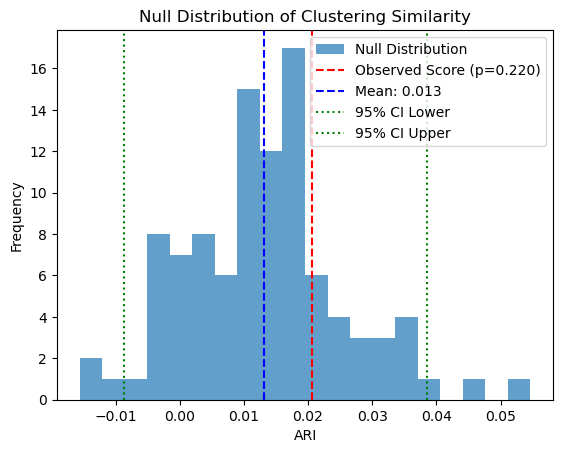

In [27]:
mean_null = np.mean(null_scores)
std_null = np.std(null_scores)
lower, upper = np.percentile(null_scores, [2.5, 97.5])
z_score = (observed_score - mean_null) / std_null
p_value = np.mean(np.array(null_scores) >= observed_score)

plt.hist(null_scores, bins=20, alpha=0.7, label='Null Distribution')
plt.axvline(observed_score, color='red', linestyle='dashed', label=f'Observed Score (p={p_value:.3f})')
plt.axvline(mean_null, color='blue', linestyle='--', label=f'Mean: {mean_null:.3f}')
plt.axvline(lower, color='green', linestyle=':', label='95% CI Lower')
plt.axvline(upper, color='green', linestyle=':', label='95% CI Upper')
plt.legend()
plt.title('Null Distribution of Clustering Similarity')
plt.xlabel('ARI')
plt.ylabel('Frequency')
plt.show()

In [28]:
true_labels = [0, 0, 1, 1, 2, 2]
predicted_labels = [0, 0, 1, 2, 2, 1]

ari = adjusted_rand_score(true_labels, predicted_labels)
print(ari)

0.16666666666666666


In [29]:
def plot_cluster_magnitudes(clusters):
    """
    Plot FFT magnitudes for each cluster, including individual magnitudes and average magnitude.

    Args:
        clusters (dict): A dictionary where keys are cluster IDs and values are lists of segments.
    """
    print("Plotting individual magnitudes and average magnitude for each cluster...")
    for cluster_id, cluster_segments in clusters.items():
        plt.figure(figsize=(10, 6))
        for segment in cluster_segments:
            plt.plot(segment['padded_fft_magnitude'], color='gray', alpha=0.3, linewidth=0.5)

        # Calculate and plot the average magnitude
        magnitudes = [segment['padded_fft_magnitude'] for segment in cluster_segments]
        avg_magnitude = np.mean(magnitudes, axis=0)
        plt.plot(avg_magnitude, color='red', linewidth=2, label='Average Magnitude')

        plt.title(f"Cluster {cluster_id}: FFT Magnitudes")
        plt.xlabel('Frequency Bin')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True)
        plt.show()

In [30]:
# plot_cluster_magnitudes(clusters)

In [31]:
def process_individual_snippets_with_wavelet(all_segments, file_names, wavelet='db4', sr=None, max_level=None):
    processed_segments_dwt = []
    
    file_idx = 0
    while file_idx < len(file_names):
        file_name = file_names[file_idx]
        print(f"Loading file: {file_name}")
        
        try:
            y, original_sr = librosa.load(file_name, sr=sr)
            y = band_stop_filter(y, original_sr, highcut=900)
        except FileNotFoundError:
            print(f"File {file_name} not found. Skipping.")
            file_idx += 1
            continue

        file_segments = [segment for segment in all_segments if segment['file_name'] == file_name]

        for idx, segment in enumerate(file_segments):
            start_time = segment['start_time']
            end_time = segment['end_time']
            
            print(f"Processing snippet {idx + 1}/{len(file_segments)}: {start_time:.2f}s to {end_time:.2f}s")

            start_idx = int(start_time * original_sr)
            end_idx = int(end_time * original_sr)
            
            snippet = y[start_idx:end_idx]
            
            # Perform DWT
            coeffs = pywt.wavedec(snippet, wavelet=wavelet, level=max_level)
            power_levels = [np.square(np.abs(c)) for c in coeffs]  # Calculate power for each level
            
            processed_segments_dwt.append({
                'file_name': file_name,
                'start_time': start_time,
                'end_time': end_time,
                'wavelet_coeffs': coeffs,
                'wavelet_power_levels': power_levels,
                'frequency_bands': pywt.scale2frequency(wavelet, np.arange(1, len(coeffs) + 1)) * original_sr / 2
            })

        file_idx += 1

    return processed_segments_dwt


In [32]:
folder_path = '../audios/lab_audios/first_batch/'
file_names = [f'{folder_path}recording_20240927_204919-{i:02d}.wav' for i in range(1,17)]
# processed_segments_wavelet = process_individual_snippets_with_wavelet(all_segments, file_names, wavelet='db4')

# # Save the results if needed
# with open(f'{folder_path}processed_segments_DWT.pkl', 'wb') as file:
#     pickle.dump(processed_segments_wavelet, file)

# print("Wavelet processing complete. Results saved.")

with open(f'{folder_path}processed_segments_DWT.pkl', 'rb') as file:
    processed_segments_wavelet = pickle.load(file)

In [33]:
def interpolate_wavelet_power_levels_to_longest(processed_segments_wavelet):
    max_length = max(
        max(len(power) for power in segment['wavelet_power_levels'])
        for segment in processed_segments_wavelet
    )
    
    for segment in processed_segments_wavelet:
        power_levels = segment['wavelet_power_levels']
        
        interpolated_power_levels = []
        for power in power_levels:
            x = np.linspace(0, 1, len(power))
            interp_func = interp1d(x, power, kind='linear', fill_value='extrapolate')  # Interpolation function
            x_new = np.linspace(0, 1, max_length)
            interpolated_power = interp_func(x_new)
            interpolated_power_levels.append(interpolated_power)
        
        segment['interpolated_power_levels'] = interpolated_power_levels
    
    return processed_segments_wavelet

def pad_wavelet_power_levels_to_longest(processed_segments_wavelet):
    max_length = max(
        max(len(power) for power in segment['wavelet_power_levels'])
        for segment in processed_segments_wavelet
    )
    max_levels = max(len(segment['wavelet_power_levels']) for segment in processed_segments_wavelet)
    
    for segment in processed_segments_wavelet:
        power_levels = segment['wavelet_power_levels']
        
        # Pad each power level to `max_length`
        padded_power_levels = [
            np.pad(power, (0, max_length - len(power)), mode='constant') for power in power_levels
        ]
        
        # Pad the segment with additional zero arrays to match `max_levels`
        while len(padded_power_levels) < max_levels:
            padded_power_levels.append(np.zeros(max_length))
        
        segment['padded_power_levels'] = padded_power_levels
    
    return processed_segments_wavelet


In [34]:
# processed_segments_wavelet = interpolate_wavelet_power_levels_to_longest(processed_segments_wavelet)

In [35]:
def plot_dwt_powers_raw(processed_segments_wavelet, num_signals=10):
    plt.figure(figsize=(15, 10))

    for i, segment in enumerate(processed_segments_wavelet[:num_signals], start=1):
        power_levels = segment['padded_power_levels']
        frequency_bands = segment['frequency_bands']  # Approximate frequency bands
        
        # Stack the padded power levels into a 2D array
        raw_power = np.vstack(power_levels)

        plt.subplot(2, 5, i)  # Arrange in a 2x5 grid
        plt.imshow(
            raw_power,
            aspect='auto',
            origin='lower',
            extent=[0, raw_power.shape[1], frequency_bands[0], frequency_bands[-1]],
            cmap='viridis',
            vmin=0,
            vmax=0.0005
        )
        plt.title(f"Segment {i}")
        plt.xlabel("Time Frames")
        plt.ylabel("Frequency Bands (Hz)")
        plt.colorbar(label="Power")

    plt.tight_layout()
    plt.show()

In [36]:
# processed_random_segments_wavelet = process_individual_snippets_with_wavelet(random_segments[:100], file_names, wavelet='db4')

# # Save the results if needed
# with open(f'{folder_path}processed_random_segments_DWT.pkl', 'wb') as file:
#     pickle.dump(processed_random_segments_wavelet, file)
    
with open(f'{folder_path}processed_random_segments_DWT.pkl', 'rb') as file:
    processed_random_segments_wavelet = pickle.load(file)

In [37]:
processed_random_segments_wavelet = interpolate_wavelet_power_levels_to_longest(processed_random_segments_wavelet)
processed_random_segments_wavelet = pad_wavelet_power_levels_to_longest(processed_random_segments_wavelet)

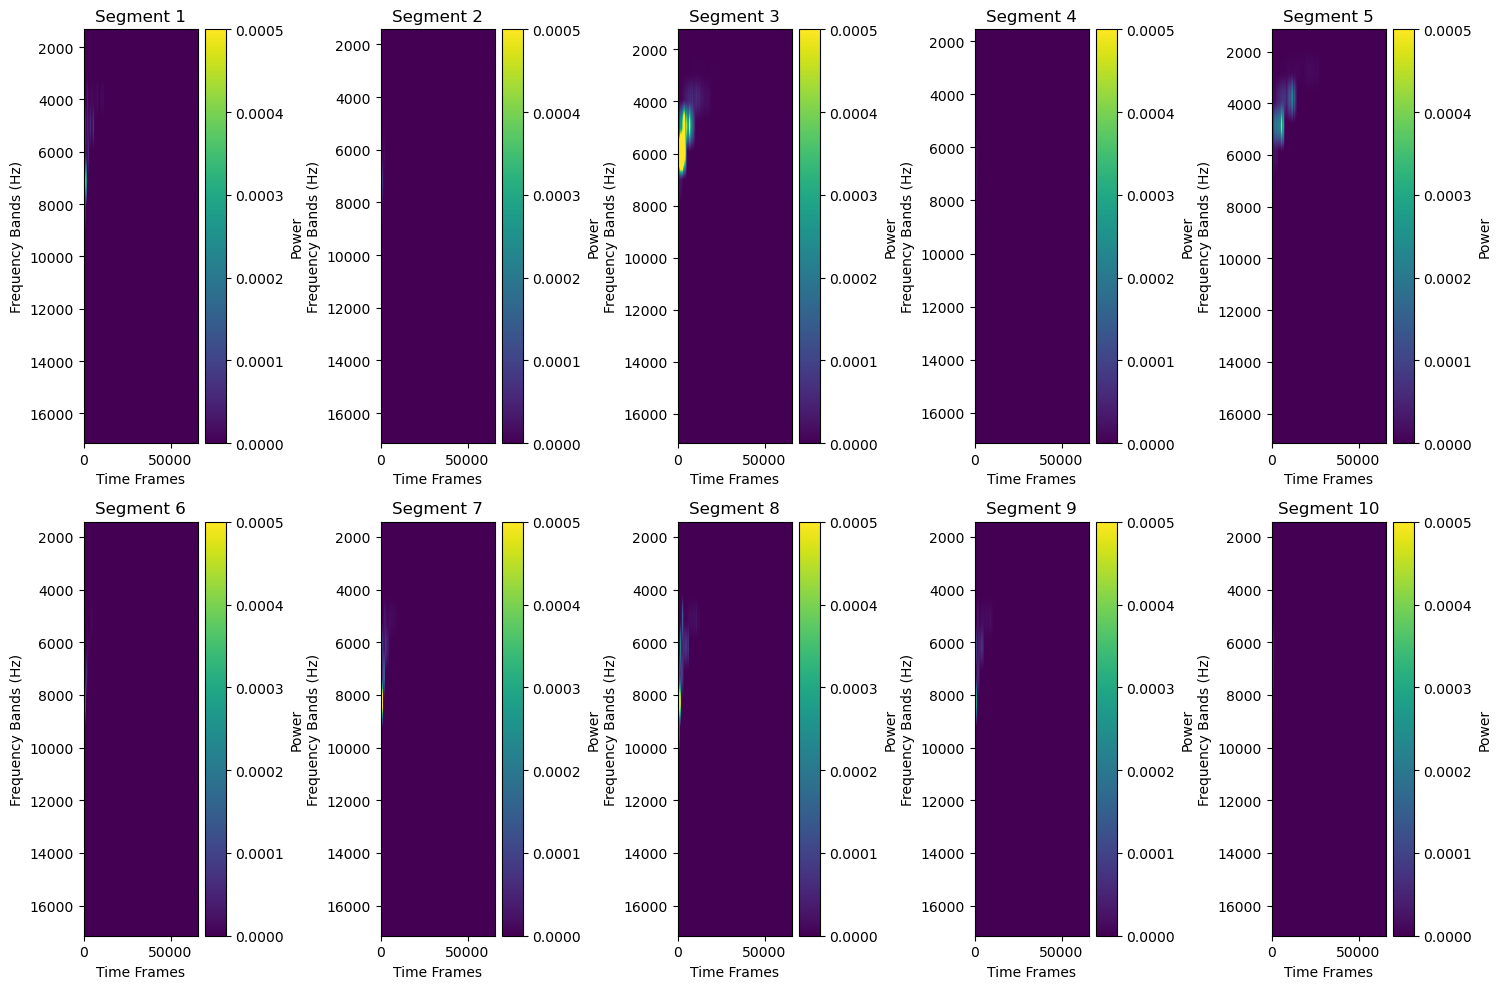

In [38]:
plot_dwt_powers_raw(processed_random_segments_wavelet, num_signals=10)

Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 1/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 2/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 3/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 4/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Groupin

Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 40/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 41/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 42/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 43/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 44/100.

Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 79/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 80/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 81/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 82/100...
Extracting and standardizing DWT magnitudes...
Performing spectral clustering with 7 clusters...
Analyzing and visualizing average magnitudes per cluster...
Grouping segments by clusters...
Iteration 83/100...
Extracting and standardizing DWT magnitudes...


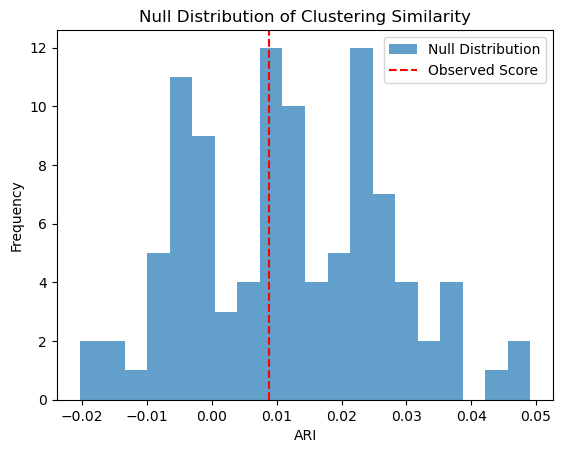

In [39]:
num_iterations = 100
n_clusters = 7
null_scores, observed_score = compute_null_distribution(
    processed_random_segments_wavelet,
    ground_truth=ground_truth_labels,
    n_clusters=n_clusters,
    num_iterations=num_iterations,
    source='DWT'
)

visualize_null_distribution(null_scores, observed_score)

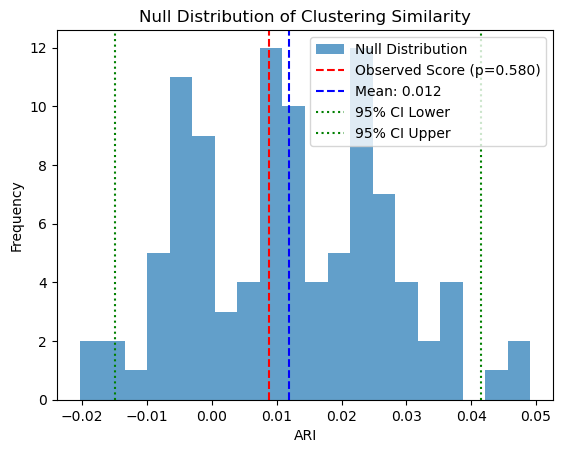

In [40]:
mean_null = np.mean(null_scores)
std_null = np.std(null_scores)
lower, upper = np.percentile(null_scores, [2.5, 97.5])
z_score = (observed_score - mean_null) / std_null
p_value = np.mean(np.array(null_scores) >= observed_score)

plt.hist(null_scores, bins=20, alpha=0.7, label='Null Distribution')
plt.axvline(observed_score, color='red', linestyle='dashed', label=f'Observed Score (p={p_value:.3f})')
plt.axvline(mean_null, color='blue', linestyle='--', label=f'Mean: {mean_null:.3f}')
plt.axvline(lower, color='green', linestyle=':', label='95% CI Lower')
plt.axvline(upper, color='green', linestyle=':', label='95% CI Upper')
plt.legend()
plt.title('Null Distribution of Clustering Similarity')
plt.xlabel('ARI')
plt.ylabel('Frequency')
plt.show()